# **Creating the dataset**

In [63]:
#run below code twice
#from line_profiler import LineProfiler
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.stats import percentileofscore

import numpy as np
import pandas as pd
import plotnine as gg
import torch
import torch.optim as optim
from dataloader import TabularDataset

import higher

from torch import nn
# from acme.utils.loggers.terminal import TerminalLogger
import dataclasses
from polyadic_sampler_classification import *
#import chex
#import haiku as hk
#import jax
#import jax.numpy as jnp
#import optax
import pandas as pd
#import warnings
import gpytorch
from torch.distributions.bernoulli import Bernoulli
#warnings.filterwarnings('ignore')
from enn import *
import enn_pipeline_classification 
#import pipeline_var_l2_loss
import seaborn as sns
#from dataloader import TabularDataset
#from var_l2_loss_estimator import *
#from ENN import basenet_with_learnable_epinet_and_ensemble_prior
import matplotlib.pyplot as plt

#wandb.init()
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import torch.nn.init as init
from datetime import datetime
 
#data from https://drive.google.com/drive/u/1/folders/1WuXIzpYLrLNH6pn9zBMx6oRCCQPRz0F1

directory = '/shared/share_mala/data/eicu_train_test/'
train_csv = 'eicu_train_final.csv'
test_csv = 'eicu_test_final.csv'

df_train = pd.read_csv(directory + train_csv)
df_test = pd.read_csv(directory + test_csv)
df = pd.concat([df_train, df_test], axis = 0)
X_col = list(df.columns)[:-1]
Y = 'EVENT_LABEL'


df = df.groupby('EVENT_LABEL', group_keys=False).apply(lambda x: x.sample(2000))
Y_data = np.array(df[Y])


In [71]:
np.mean(Y_data)

0.5

# K-means

In [64]:
# Normalize data
n_cluster = 10
data = np.array(df[X_col])
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)
kmeans = KMeans(n_clusters = n_cluster, random_state = 1)
kmeans.fit(data_normalized)

/user/ym2865/.conda/envs/yuanzhe_new/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


KMeans(n_clusters=10, random_state=1)

In [65]:
n = df.shape[0]
clusters = kmeans.labels_
centers = kmeans.cluster_centers_

distances = np.linalg.norm(data_normalized - centers[clusters], axis=1)

threshold_list = []
threshold_larger_list = []
for i in range(kmeans.n_clusters):
    cluster_distances = distances[clusters == i]
    #center points
    threshold_list.append(np.percentile(cluster_distances, 0.05))
    threshold_larger_list.append(np.percentile(cluster_distances, 0.5))

n_cluster  = 10
center_ind_list = [[]] * n_cluster
all_data_index_candidate_list = [[]] * n_cluster #candidates, we only want some clusters later


for j in range(n):
    cluster = clusters[j] #retrieve cluster #
    if distances[j] <= threshold_list[cluster]:
        center_ind_list[cluster].append(j)
    if distances[j] <= threshold_larger_list[cluster]:
        all_data_index_candidate_list[cluster].append(j)
        
#compare each cluster
for i in range(kmeans.n_clusters):
    print(i, np.mean(Y_data[clusters == i]))
    
    
train_cluster = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] #[0]
test_cluster = [0,6,3,4,2]
pool_cluster = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

def get_whole_index(List, subset):
    res = []
    for j in subset:
        res += List[j]
    return res

train_index = get_whole_index(all_data_index_candidate_list, train_cluster)
test_index = get_whole_index(all_data_index_candidate_list, test_cluster)
pool_index = get_whole_index(all_data_index_candidate_list, pool_cluster)

0 0.6644736842105263
1 0.5252100840336135
2 0.2847124824684432
3 0.851063829787234
4 0.38509316770186336
5 0.5428571428571428
6 0.3068391866913124
7 0.4975186104218362
8 0.42857142857142855
9 0.9651162790697675


# Save a predictor

In [66]:
#/user/ym2865/Adaptive Sampling/enn_classification
class Neural_Network(torch.nn.Module):    
    # build the constructor
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
        # Initialize weights using Gaussian distribution
        init.normal_(self.fc1.weight, mean=0.0, std=0.01)  # Mean 0, Standard deviation 0.01
        init.normal_(self.fc2.weight, mean=0.0, std=0.01)  # Mean 0, Standard deviation 0.01
        init.normal_(self.fc3.weight, mean=0.0, std=0.01)  # Mean 0, Standard deviation 0.01
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x
    
X_train = torch.tensor(data[train_index], dtype=torch.float32)
y_train = torch.tensor(Y_data[train_index], dtype=torch.float32) 
y_train = torch.unsqueeze(y_train, -1)
# Hyperparameters
epochs = 800  # Number of training iterations
learning_rate = 0.01

torch.manual_seed(123)

# Model, Loss and Optimizer
model = Neural_Network(input_size=X_train.shape[1], hidden_size = 3, output_size=1)
criterion = torch.nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    # Forward pass: Compute predicted y by passing X to the model
    y_pred = model(X_train)
    
    #print test/ pool loss 
    #print X/Y train/ test/ pool
    # Compute and print loss
    loss = criterion(y_pred, y_train)
    if epoch % 10 == 0:  # Print every 10th epoch
        print(f'Epoch {epoch}, Loss: {loss.item()}')

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
current_time = datetime.now()
time_str = current_time.strftime("%Y-%m-%d_%H:%M:%S")

model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save(directory +'predictor/' + 'predictor' +time_str  + '.pt') # Save
print('File_name', 'predictor' +time_str  + '.pt')

Epoch 0, Loss: 0.5909654498100281
Epoch 10, Loss: 0.5870773792266846
Epoch 20, Loss: 0.583375871181488
Epoch 30, Loss: 0.579849362373352
Epoch 40, Loss: 0.5764880180358887
Epoch 50, Loss: 0.5732825398445129
Epoch 60, Loss: 0.5702245831489563
Epoch 70, Loss: 0.5673062801361084
Epoch 80, Loss: 0.5645201206207275
Epoch 90, Loss: 0.5618592500686646
Epoch 100, Loss: 0.5593171119689941
Epoch 110, Loss: 0.5568873286247253
Epoch 120, Loss: 0.5545637011528015
Epoch 130, Loss: 0.5523404479026794
Epoch 140, Loss: 0.5502113699913025
Epoch 150, Loss: 0.5481702089309692
Epoch 160, Loss: 0.5462102293968201
Epoch 170, Loss: 0.544323742389679
Epoch 180, Loss: 0.542500913143158
Epoch 190, Loss: 0.5407290458679199
Epoch 200, Loss: 0.5389887690544128
Epoch 210, Loss: 0.5372488498687744
Epoch 220, Loss: 0.5354546308517456
Epoch 230, Loss: 0.5335022807121277
Epoch 240, Loss: 0.5311847925186157
Epoch 250, Loss: 0.5280895233154297
Epoch 260, Loss: 0.5235174298286438
Epoch 270, Loss: 0.5170207023620605
Epoch 2

In [72]:
class TabularDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
  
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, idx):

        return self.x[idx], self.y[idx]
    
def ENN_training(x_train, y_train,model_config, enn_config, device, if_print):
    
    dataset_train = TabularDataset(x = x_train, y = y_train)
    dataloader_train = DataLoader(dataset_train, batch_size=train_cfg.batch_size, shuffle=True) 
    sample, label = dataset_train[0]
    input_feature_size = sample.shape[0]  
    
    ENN_model = basenet_with_learnable_epinet_and_ensemble_prior(input_feature_size, enn_config.basenet_hidden_sizes, model_config.n_classes, enn_config.exposed_layers, enn_config.z_dim, enn_config.learnable_epinet_hiddens, enn_config.hidden_sizes_prior, enn_config.seed_base, enn_config.seed_learnable_epinet, enn_config.seed_prior_epinet, enn_config.alpha).to(device)

    # Need to do this because ENN_model itself has some seeds and we need to set the seed for the whole training process here
    torch.manual_seed(enn_cfg.seed_learnable_epinet)
    np.random.seed(enn_cfg.seed_learnable_epinet)
    if device=="cuda":
        torch.cuda.manual_seed(seed_training) # Sets the seed for the current GPU
        torch.cuda.manual_seed_all(seed_training) # Sets the seed for all GPUs
    
        

    loss_fn_init = nn.CrossEntropyLoss()
    optimizer_init = optim.Adam(ENN_model.parameters(), lr=enn_config.ENN_opt_lr, weight_decay=enn_config.ENN_opt_weight_decay)
    enn_loss_list = []
    for i in range(enn_config.n_ENN_iter):
        ENN_model.train()
        for (inputs, labels) in dataloader_train:   #check what is dim of inputs, labels, ENN_model(inputs,z)
            aeverage_loss = 0
            for j in range(enn_config.z_samples): 
                z = torch.randn(enn_config.z_dim, device=device)
                optimizer_init.zero_grad()
                outputs = ENN_model(inputs,z)
                
                #print("outputs:", outputs)
                #print("labels:", labels)
                #labels = torch.tensor(labels, dtype=torch.long, device=device)
                
                loss = loss_fn_init(outputs, labels.squeeze().long())/enn_config.z_samples
                loss.backward()
                aeverage_loss += loss

            optimizer_init.step()

        enn_loss_list.append(float(loss.detach().to('cpu').numpy())) 
    if if_print == 0:
        plt.plot(list(range(len(enn_loss_list))),enn_loss_list)
        plt.title('ENN loss vs training iter')
        plt.show()
    
    return ENN_model

class Network(nn.Module):
    def __init__(self, constant_value=1.0, output_size=1):
        super(ConstantValueNetwork, self).__init__()
        # Define the constant value and output size
        #self.constant_value = nn.Parameter(torch.tensor([constant_value]*output_size), requires_grad=False)
        self.output_size = output_size

    def forward(self, x):
        # x is your input tensor. Its value is ignored in this model.
        # Return a 1-D tensor with the constant value for each item in the batch.
        batch_size = x.size(0)  # Get the batch size from the input
        return torch.sigmoid(x)
        #return self.constant_value.expand(batch_size, self.output_size)

Predictor = model_scripted

train_x = torch.tensor(data[train_index], dtype=torch.float32)
train_y_binary = torch.tensor(Y_data[train_index], dtype=torch.float32) 
train_x = torch.tensor(data, dtype=torch.float32)
train_y_binary = torch.tensor(Y_data, dtype=torch.float32) 


test_x = torch.tensor(data[test_index], dtype=torch.float32)
test_y_binary = torch.tensor(Y_data[test_index], dtype=torch.float32) 

pool_x = torch.tensor(data[pool_index], dtype=torch.float32)
pool_y_binary = torch.tensor(Y_data[pool_index], dtype=torch.float32) 

Z_dim = 8
if_print = 0

#dataset_cfg = enn_pipeline_classification.DatasetConfig(direct_tensors_bool, csv_file_train, csv_file_test, csv_file_pool, y_column, shuffle)
z_dim = 8
model_cfg = enn_pipeline_classification.ModelConfig(access_to_true_pool_y = 1, batch_size_query = 10, temp_k_subset = 0.1, meta_opt_lr = 0.1, meta_opt_weight_decay = 0, n_classes = 2, temp_recall = 0.4)
train_cfg = enn_pipeline_classification.TrainConfig(n_train_iter = 100, n_samples = 10, G_samples = 5, n_iter_noise = 10, batch_size = 10) #temp_var_recall needs to be added as a new variable here i var recall setting
enn_cfg = enn_pipeline_classification.ENNConfig(basenet_hidden_sizes = [50,50], exposed_layers = [True], z_dim = z_dim, learnable_epinet_hiddens = [15,15], hidden_sizes_prior = [5], seed_base = 2, seed_learnable_epinet = 2, seed_prior_epinet = 2, alpha = 10, n_ENN_iter = 1000, ENN_opt_lr = 0.01, ENN_opt_weight_decay = 0.05, z_samples = 40, stdev_noise=0)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset_test = TabularDataset(x = test_x, y = test_y_binary)
dataloader_test = DataLoader(dataset_test, batch_size=train_cfg.batch_size, shuffle=True) 


# Initial var of recall

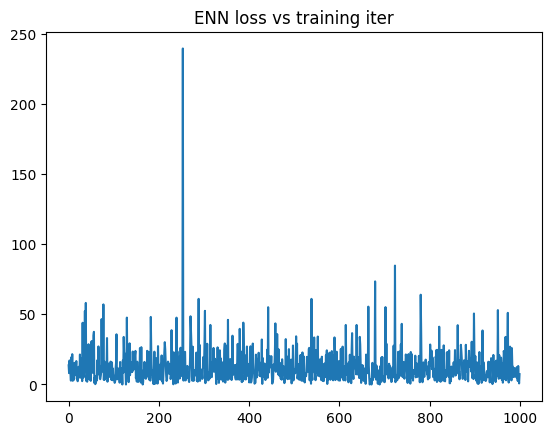

tensor(0., grad_fn=<SubBackward0>)


In [73]:
ENN_trained = ENN_training(train_x, train_y_binary, model_cfg, enn_cfg, device , if_print )
meta_loss = var_recall_estimator(ENN_trained, dataloader_test, Predictor, device, para = {'tau': train_config.temp_var_recall, 'z_dim': train_config.z_dim, 'N_iter': train_config.N_iter ,'if_print':if_print, 'seed_var_recall':train_config.seed_var_recall, 'N_iter_var_recall_est':train_config.N_iter_var_recall_est})     #see where does this calculation for meta_loss happens that is it outside the innerloop_ctx or within it
print(meta_loss)

z_pool = torch.randn(z_dim, device=device)
print(ENN_trained(train_x, z_pool))

In [79]:
z_pool = torch.randn(z_dim, device=device)
print(ENN_trained(train_x, z_pool))

tensor([[ -822.2144,  -455.9166],
        [  506.3035,  -164.2565],
        [ -876.4700,  -869.9448],
        ...,
        [-1229.4727,   386.2534],
        [ -749.2487,  -397.9944],
        [  592.2394,  -183.3978]], grad_fn=<AddBackward0>)


# After sample cluster centroid points  

In [107]:
# new_train_y_with_pool = torch.cat((train_x, pool_x[pool_sample_idx]), 0)
# new_train_x_with_pool = torch.cat((train_y_binary, pool_y_binary[pool_sample_idx]), 0)


# new_pool_x = pool_x[pool_sample_idx][pool_x[pool_sample_idx] >= 0.25]
# new_pool_x = torch.unsqueeze(new_pool_x,-1)
# new_pool_y = pool_y_binary[pool_sample_idx][torch.squeeze(pool_x[pool_sample_idx] >= 0.25)]
# new_train_y_with_pool = torch.cat((train_x, new_pool_x), 0)
# new_train_x_with_pool = torch.cat((train_y_binary, new_pool_y), 0)


# ENN_trained = ENN_training(new_train_y_with_pool, new_train_x_with_pool, model_cfg, enn_cfg, device , if_print )
# meta_loss = var_recall_estimator(ENN_trained, dataloader_test, Predictor, device, para = {'tau': train_config.temp_var_recall, 'z_dim': train_config.z_dim, 'N_iter': train_config.N_iter ,'if_print':if_print, 'seed_var_recall':train_config.seed_var_recall, 'N_iter_var_recall_est':train_config.N_iter_var_recall_est})     #see where does this calculation for meta_loss happens that is it outside the innerloop_ctx or within it
# print('Var of recall after sampling pool data',meta_loss)